# Data Programming cw 2 

## contents
- Introduction
- Reseach Question
- Aims and Objectives
- Data Acquisition
- Saving the Dataset
- Data Screening and Cleaning
- Analysis of all Journals Numerical Data
    - Do experimental papers outnumber hypothesis and theory papers?
    - Trends in the top 100 most cited papers
    - Summary for the numerical analysis of all journals
- Analysis of Hypothesis and Theory Articles Numerical Data
    - Summary for the numerical analysis of hypothesis and theory papers 
- Analysis of Hypothesis and Theory Articles Text Data
- Conclusion and Discussion

## Introduction
The exploratory analysis of the Frontiers journal metadata in the previous coursework indicated that more insights are likely to be obtained from looking at specific journals and the articles they contain. This work will therefore focus on obtaining each article from each one of the Frontiers neuroscience journals and organising them and their associated data in one large dataset. This will enable a more in-depth analysis of the topics and the impact they have in the field of neuroscience.

As detailed in the exploratory analysis, Frontiers (https://www.frontiersin.org), is the 3rd most cited and the 6th largest publisher with 1.9 billion article views and downloads available worldwide making it an excellent candidate for this particular analysis. The focus of this analysis will be oriented towards understanding the relationship between hypothesis and theory vs experimental findings across the previously identified 19 journals that contain the word neuro in the title (full list in the data acquisition section below). Hypothesis and theory works are considered essential in the field for consolidating experimental findings and providing guidance for further research. However, in recent years there is a general sense among many in the community that there is an abundance of experimental findings with a distinct lack of theoretical work attempting to provide any kind of coherent structure to these findings. Furthermore, some researchers have expressed concern that many of these experimental findings are chance correlations that hold no significant explanatory power and that much of the current understanding in neuroscience is based on such erroneous data meaning it is unlikely any meaningful theories can be developed. All this comes at a time when the academic publishing system is coming under increasing scrutiny. Therefore, attempting to understand what the data around these issues has to say about the current state of the field of neuroscience may help elucidate where further innovation is possible and identify current barriers to it.

note: The words article and paper are used interchangeably 

## Aims and Objectives
1. Obtain a dataset containing all articles as associated data from all the specified neuroscience journals.  

2. Identify if there a lack of hypothesis and theory articles compared to experimental articles and if so, does the numerical data provide evidence for why this may be the case?

3. Informed by the analysis of the numerical data, analyse the hypothesis and theory articles starting with the text of the article titles to help identify relevant topics.

4. Analyse the text of these articles using sentiment analysis and TF-IDF to try and understand how these topics are influencing the field and what they may indicate are the problems that need to be solved.


Imports we will need

In [ ]:
from bs4 import BeautifulSoup
import requests
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions
from selenium.common.exceptions import NoSuchElementException
from webdriver_manager.chrome import ChromeDriverManager
import time
import re
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk import FreqDist 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

## Data acquisition
The neuroscience journals identified in the exploratory analysis are made into a list so they can be looped through by the web scraper. 
#### NOTE: The full list takes over an hour to scrape so i have made a shorter demo list with two of the journals that have very few papers so it can be run quickly to show how this part of the code works.

In [ ]:
aging = "https://www.frontiersin.org/journals/aging-neuroscience/articles"
behavioural = "https://www.frontiersin.org/journals/behavioral-neuroscience/articles"
cellular = "https://www.frontiersin.org/journals/cellular-neuroscience/articles"
computational = "https://www.frontiersin.org/journals/computational-neuroscience/articles"
evolutionary = "https://www.frontiersin.org/journals/evolutionary-neuroscience/articles"
human = "https://www.frontiersin.org/journals/human-neuroscience/articles"
integrative = "https://www.frontiersin.org/journals/integrative-neuroscience/articles"
molecular = "https://www.frontiersin.org/journals/molecular-neuroscience/articles"
neuroanatomy = "https://www.frontiersin.org/journals/neuroanatomy/articles"
neuroenergetics = "https://www.frontiersin.org/journals/neuroenergetics/articles"
neuroengineering = "https://www.frontiersin.org/journals/neuroengineering/articles"
neuroergonomics = "https://www.frontiersin.org/journals/neuroergonomics/articles"
neuroimaging = "https://www.frontiersin.org/journals/neuroimaging/articles"
neuroinformatics = "https://www.frontiersin.org/journals/neuroinformatics/articles"
neurology = "https://www.frontiersin.org/journals/neurology/articles"
neurorobotics = "https://www.frontiersin.org/journals/neurorobotics/articles"
neuroscience = "https://www.frontiersin.org/journals/neuroscience/articles"
synaptic = "https://www.frontiersin.org/journals/synaptic-neuroscience/articles"
systems = "https://www.frontiersin.org/journals/systems-neuroscience/articles"

# journals = [aging, behavioural, cellular, computational, evolutionary, human, integrative, molecular,
#             neuroanatomy, neuroenergetics, neuroengineering, neuroergonomics, neuroimaging, neuroinformatics,
#             neurology, neurorobotics, neuroscience, synaptic, systems]

journals = [evolutionary, neuroimaging]

#### Handle the cookies popup

In [ ]:
def handle_cookies(driver):
    wait = WebDriverWait(driver, 10)
    cookies = wait.until(expected_conditions.element_to_be_clickable((By.ID, "onetrust-accept-btn-handler")))
    cookies.click()

#### Page scrolling
For some reason unknown to me the old method of scrolling used in the exploratory analysis doesn't seem to work on these pages. To overcome this the height of the page is checked at each iteration of a loop and then the page is scrolled by that amount. The added sleep command gives the page time to load and means the height changes on every iteration of the loop so it can be checked. It is not a very elegant solution but seems to work fine albeit a little slower.

In [ ]:
def scroll_page(driver):
    previous_height = driver.execute_script("return document.documentElement.scrollHeight")
    driver.execute_script("window.scrollTo(0, " + str(previous_height) + ");")
    time.sleep(2)
    new_height = driver.execute_script("return document.documentElement.scrollHeight")
    return previous_height, new_height

#### Error handling 
Unfortunately, selenium does not provide the ability to check request response codes when retrieving the webpage. This function uses the python requests library to check and catch 404's and any other errors.

In [ ]:
def check_page_response(journal):
    try:
        r = requests.get(journal)
        print(r, journal)
    except requests.exceptions.RequestException as e:
        print(e)

#### NOTE: This can take over an hour for all the journals to be scraped so this demo uses the smaller subset of journals. The full dataset is imported later in the notebook.

Now loop through all journals and extract the data. Each journal object containing the article data is added to the list soup. The while loop runs until the article page of that journal cannot be scrolled anymore and then tries to scroll again two more times before performing a final check and breaking if the end of the journal has been reached. The next journal is then loaded, and the process repeated until all journal pages have been stored in the soup list. There is also an exception handler in case the cookies popup does not appear.

In [ ]:
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
soup = []

for journal in journals:
    check_page_response(journal)
    driver.get(journal)
    driver.maximize_window()  # make window bigger so more content can be loaded at once for faster scraping.
    
    if journals[0] == journal:
        try:
            handle_cookies(driver)
        except NoSuchElementException as exception: # if no cookies popup hanel exeption
            print ("No cookies popup detected")

    while True:
        previous_height, new_height = scroll_page(driver)
        if previous_height == new_height: # check the page cant be scrolled any more
            for i in range(2):
                scroll_page(driver)
            _, new_height_check = scroll_page(driver)    
            if previous_height == new_height_check: # finally check the page height and break if its not changing
                break

    soup.append(BeautifulSoup(driver.page_source, 'html.parser'))

#### Check the correct number of journals have been scraped

In [ ]:
print("Journals scraped =", len(soup))

#### Extracting article data
The only function that is maybe not self-explanatory is the first one "get_article_cards". The article data is displayed on the webpage in this "card" format and so each html class "CardArticle" contains all of the article information we are collecting. once these article cards have been obtained, they can be passed through the rest of the functions to extract the relevant data. This data is stored in dictionaries and eventually converted into a single dataframe that contains all journals and their respective articles with the corresponding data displayed in the columns of each row with the article title being the index. This can be seen in the next few cells.

In [ ]:
def get_article_cards(soup):
    scraped_article_cards = soup.find_all('article', class_='CardArticle')
    article_cards = []
    for article_card in scraped_article_cards:
        article_cards.append(article_card)
    return article_cards


def get_article_metrics(article):
    article_metrics = article.find('ul', class_='CardArticle__metrics')
    split_metrics = article_metrics.text.split()
    is_float = re.compile("^[0-9]*.[0-9]*$")
    keys = []
    values = []
    for metric in split_metrics:
        metric = metric.replace(",", "")
        if metric.isdigit() or is_float.match(metric):
            values.append(float(metric))
        else:
            keys.append(metric)
    return dict(zip(keys, values))


def get_article_authors(article):
    article_authors = article.find('ul', class_='CardArticle__authors')
    authors = {}
    author_index = 1
    for author in article_authors:
        if author != "\n":
            authors.update({author_index: author.text.strip()}) # add each author as a numbered column. Number 1 is the primary author number 2 the secondary and so on...
            author_index = author_index + 1
    authors.update({"article authors": len(authors)})
    return authors


def get_title(article_title):
    title = article_title.text.replace("\n", "")
    title = re.sub(' +', ' ', title)
    return title.strip()


def get_article_status(article):
    article_date = article.find('p', class_='CardArticle__date')
    status = article_date.text.strip().split()
    return status[0]


def get_article_date(article):
    article_date = article.find('p', class_='CardArticle__date')
    date_info = article_date.text.strip().split()
    date_string = date_info[2] + date_info[3] + date_info[4]
    date = datetime.strptime(date_string, '%d%b%Y')
    return date


def get_article_data(article_cards):
    article_data = {}
    for article in article_cards:
        article_title = article.find('h1', class_='CardArticle__title')
        article_type = article.find('p', class_='CardArticle__type')
        article_journal = article.find('div', class_='CardArticle__journal__name')
        title = get_title(article_title)

        article_data[title] = {"article type": article_type.text,
                               "article date": get_article_date(article),
                               "article status": get_article_status(article),
                               "article journal": article_journal.text}
        article_data[title].update(get_article_authors(article))
        article_data[title].update(get_article_metrics(article))
    return article_data

dataset = {}
for journal in range(len(soup)):
    article_cards = get_article_cards(soup[journal])
    dataset.update(get_article_data(get_article_cards(soup[journal])))

In [ ]:
df = pd.DataFrame(dataset)
df_transpose = df.transpose()
df_raw = df_transpose.copy()

In [ ]:
display(df_raw)

## Save dataset 
Now the raw dataset can be saved so we have an easy to access copy to avoid running the web scraper more than necessary. I have previously saved a version of the full dataset but I included the commented out command here just for completeness so this section can still be run and shown to be saveable if that is required.

In [ ]:
# df_raw.to_excel("demo_journal_data.xlsx")

## Data screening and cleaning
Importing the full dataset from excel shows that we have 52615 articles. However, importing the dataset from excel seems to add a new numbered index column and leave the article title as an unnamed column. We can update this by renaming the unnamed column to article title and using the new numerical index where appropriate.  

In [7]:
df_imported = pd.read_excel("raw_journal_data.xlsx")

In [8]:
df_imported.rename(columns={'Unnamed: 0':'article title'}, inplace=True)

In [9]:
df_imported.shape

(52615, 18)

In [10]:
display(df_imported)

,article title,article type,article date,article status,article journal,1,2,3,article authors,views,citations,4,5,6,7,8,9,10
0,Neurobiology of human language and its evoluti...,Editorial,2013-01-28,Published,Frontiers in Evolutionary Neuroscience,Angela Dorkas Friederici,Michael Petrides,Constance Scharff,3,68792.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Birdsong: Is It Music to Their Ears?,Original Research,2012-11-28,Published,Frontiers in Evolutionary Neuroscience,Sarah E. Earp,Donna L. Maney,NaN,2,91655.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Life History Theory and Social Psychology,General Commentary,2012-09-03,Published,Frontiers in Evolutionary Neuroscience,Donald Sacco,Karol Osipowicz,NaN,2,68990.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Birds, primates, and spoken language origins: ...",Review,2012-08-16,Published,Frontiers in Evolutionary Neuroscience,Christopher I Petkov,Erich Jarvis,NaN,2,90480.0,246.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Is dorsal anterior cingulate cortex activation...,Original Research,2012-07-27,Published,Frontiers in Evolutionary Neuroscience,Taishi Kawamoto,Keiichi Onoda,Ken'ichiro Nakashima,6,73730.0,54.0,Hiroshi Nittono,Shuhei Yamaguchi,Mitsuhiro Ura,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52610,Associative and non-associative plasticity in ...,Original Research,2008-06-24,Published,Frontiers in Systems Neuroscience,Paul Szyszka,Alexander Galkin,Randolf Menzel,3,10668.0,90.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52611,Comparing the feature selectivity of the gamma...,Original Research,2008-06-17,Published,Frontiers in Systems Neuroscience,Philipp Berens,Georgios A Keliris,Alexander S Ecker,5,12423.0,100.0,Nikos K Logothetis,Andreas S Tolias,NaN,NaN,NaN,NaN,NaN
52612,Recollection- and familiarity-based decisions ...,Original Research,2008-05-26,Published,Frontiers in Systems Neuroscience,Martin Wiesmann,Alumit Ishai,NaN,2,7163.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52613,Category-specific responses to faces and objec...,Original Research,2008-03-28,Published,Frontiers in Systems Neuroscience,Kari L Hoffman,Asif A Ghazanfar,Isabel Gauthier,4,9271.0,11.0,Nikos K Logothetis,NaN,NaN,NaN,NaN,NaN,NaN


#### Handling the Null values
Checking the data for null values shows the data is a lot more complete than the metadata used in the exploratory analysis. Most of the null values are for the additional author columns with column 1, for the primary authors, having no null values so every paper has at least one stated author.

the null values will be Handled with the following changes:

1. We will assume that articles with null values for citations and views do not have any citations and views and so we can change this to 0.

2. The rest of the null values are made up of there being no more authors on the papers in the author columns and so we can set these to the string "None". We have already checked that every paper has a primary author.

In [11]:
print(df_imported.isnull().sum())
print("total =", df_imported.isnull().sum().sum())

article title          0
article type           0
article date           0
article status         0
article journal        0
1                      0
2                   2240
3                   8246
article authors        0
views                958
citations          15486
4                  15427
5                  22478
6                  28691
7                  34151
8                  38659
9                  42406
10                 45233
dtype: int64
total = 253975


In [132]:
df_handle_nulls = df_imported.copy()

df_handle_nulls['views'].fillna(0, inplace=True)
df_handle_nulls['citations'].fillna(0, inplace=True)

df_handle_nulls[[2, 3, 4, 5, 6, 7, 8, 9, 10]] = df_handle_nulls[[2, 3, 4, 5, 6, 7, 8, 9, 10]].fillna("None")

print("total Null values =", df_handle_nulls.isnull().sum().sum())

total Null values = 0


#### Data Validation
Here the data is checked for obvious mistakes such as out of bounds values like negative numbers of authors etc.
We also check some very large looking maximum values like the one for "views" by confirming the numbers on the associated website page for the article:
https://www.frontiersin.org/articles/10.3389/fnagi.2018.00168/full

In general the data is looking quite accurate and complete.

In [13]:
df_validate = df_handle_nulls.copy()

print("minimum number of authors =", df_validate["article authors"].min())
print("maximum number of authors =", df_validate["article authors"].max())

df_validate.loc[df_validate["views"] == df_validate["views"].max()]

minimum number of authors = 1
maximum number of authors = 10


,article title,article type,article date,article status,article journal,1,2,3,article authors,views,citations,4,5,6,7,8,9,10
3856,Feeling How Old I Am: Subjective Age Is Associ...,Original Research,2018-06-07,Published,Frontiers in Aging Neuroscience,Seyul Kwak,Hairin Kim,Jeanyung Chey,4,3552721.0,44.0,Yoosik Youm,None,None,None,None,None,None


## Analysis of all Journals Numerical Data
Now the data set can be used easily let’s take a look at the data from a high level and see if there are any patterns that are immediately obvious and/or any patterns relevant to our aims and objectives.

In [14]:
df_describe = df_handle_nulls.copy()

Set the graph style to seaborn for easer reading.

In [15]:
plt.style.use("seaborn")

### Do experimental papers outnumber hypothesis and theory papers?

#### papers by article type
The neuroscience literature is overwhelmingly dominated by papers that are categorised as original research with hypothesis and theory, while not being the smallest category, making up a small fraction of the overall papers. Here we are assuming original research means some form of experiment and analysis, but this may need further clarification. It is also still unclear as to what is the ideal ratio of experimental to theoretical work or if there is such a thing. It is likely to be very context dependent. This result shows experimental work does most likely vastly outnumber theoretical work.

<AxesSubplot:xlabel='article type', ylabel='number of papers'>

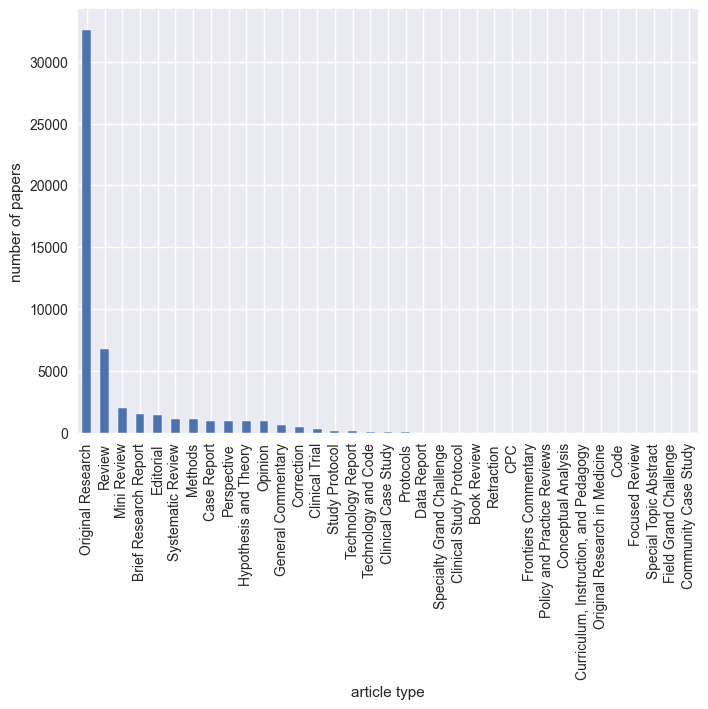

In [16]:
df_describe['article type'].value_counts().plot(kind='bar', xlabel='article type', ylabel='number of papers')

#### Number of papers published per journal 
This dominance of original research papers could be explained, in part, by the journals publishing the most papers being more oriented towards producing that kind of research. Here we can see that the journals Frontiers in Neurology, Human Neuroscience, and Neuroscience account for roughly 26000 papers which is about 50% of all the papers in the dataset. In comparison, Frontiers in systems and computational neuroscience which are more known for theoretical work account for well under 4000 which is less than 7% of the total number of papers. One perspective here that is also important to note is that of the difficulty of the problems to be solved and what are the most significant outstanding problems in neuroscience that require solving?   

<AxesSubplot:xlabel='journal name', ylabel='number of papers'>

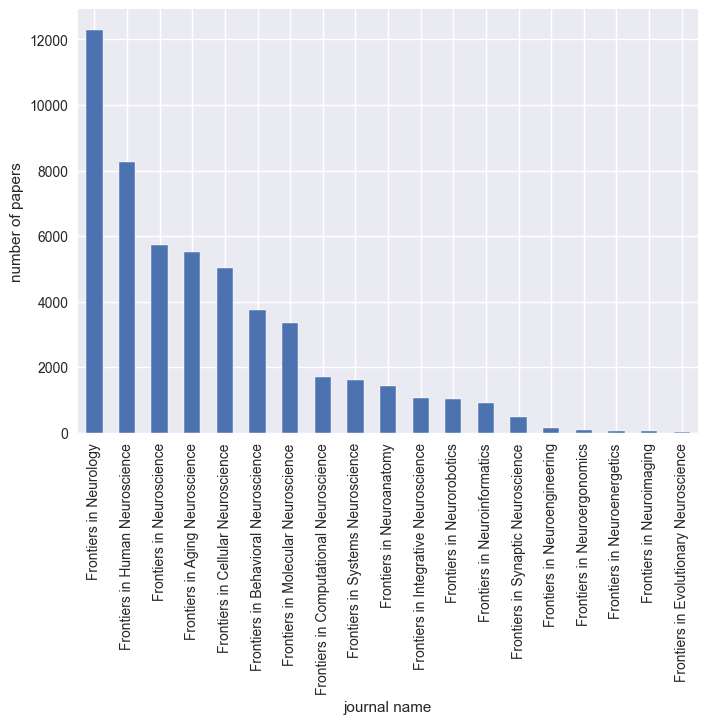

In [17]:
df_describe['article journal'].value_counts().plot(kind='bar', xlabel='journal name', ylabel='number of papers')

#### Number of authors per paper
Some further information that is interesting to note is that papers with single authors are least common when looking at all the journals collectively and that the maximum number of ten authors is the most common amount of authors for a single paper, which seems surprising. Not only that but the number of authors per paper seems to increase linearly with the number of papers published. This could speak to the nature of the publishing system where it could be more advantageous for labs and/or individuals to all appear on a single paper than produce their own individually. Or for everyone in a given institution to put as many people on each publishable article as possible (The popular term "publish or perish" comes to mind). But does this have an impact on hypothesis and theory articles?

<AxesSubplot:xlabel='number of authors', ylabel='number of papers'>

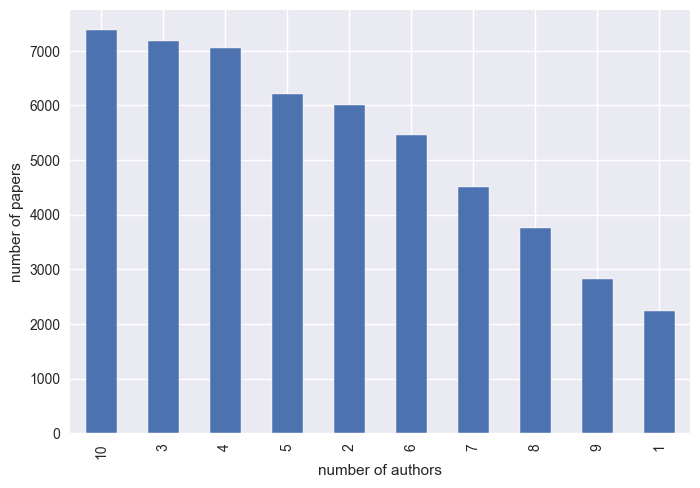

In [18]:
df_describe['article authors'].value_counts().plot(kind='bar', xlabel='number of authors', ylabel='number of papers')

#### Primary authors
Of the primary authors, we can see that 16 papers is the maximum for an individual to have published as the primary author and 15 to be more common. 

In [133]:
df_describe[1].value_counts().head()

Jing Wang           16
Xin Wang            15
Wei Wang            15
Wei Li              15
Grant L. Iverson    15
Name: 1, dtype: int64

#### looking at the numerical data pair plot.
The pair plots here do not seem to tell us much except there are some significant outliers in both citations and views. This is unlike the exploratory analysis that had citations and views highly and significantly correlated. However, the outliers are likely playing a more significant role in this dataset. Interestingly, we also don’t see a significant correlation between number of authors a given article has and the number of citations or views that article gets and if anything, there is a slight negative correlation. This indicates that there may be other reasons for publishing papers with many authors.

authors and citations correlation = -0.11273965477482681
authors and views correlation = -0.06842564777845632
citations and views correlation = 0.262268459452169


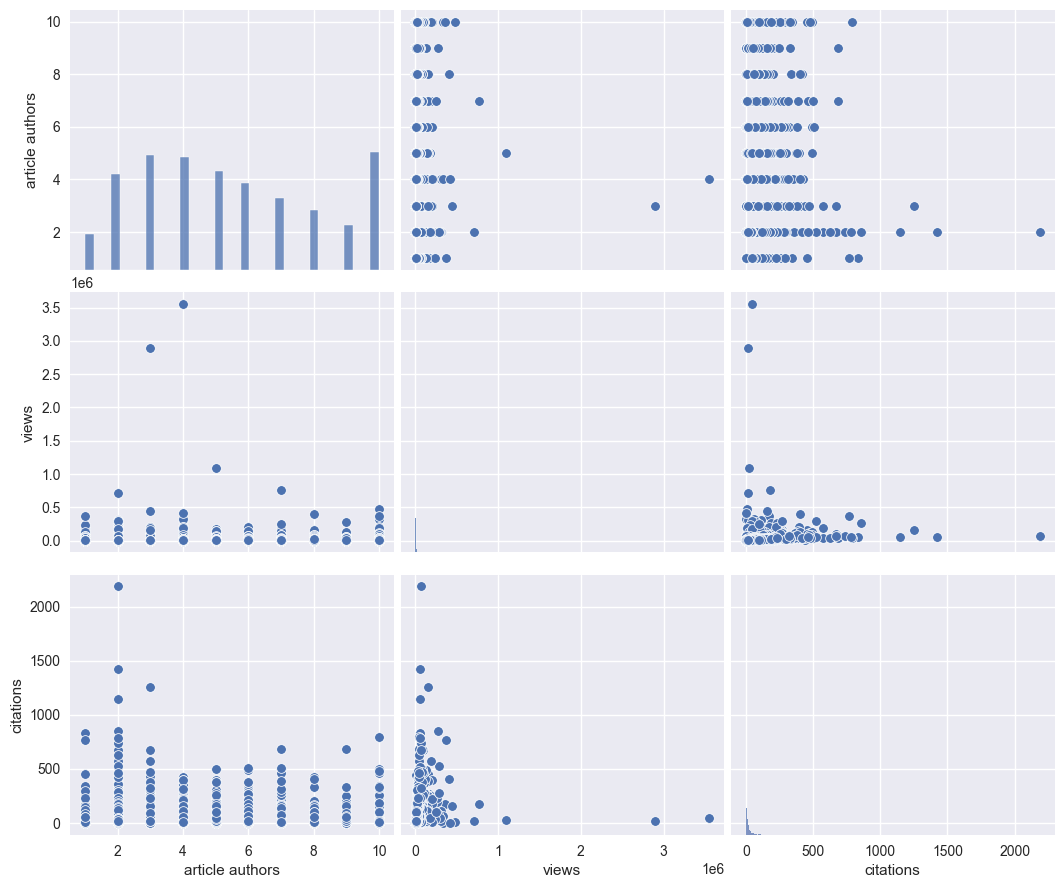

In [20]:
sns.pairplot(df_describe[['article authors','views', 'citations']], height=3, aspect=1.2)

print("authors and citations correlation =", df_describe['article authors'].corr(df_describe['citations'], method="pearson"))
print("authors and views correlation =", df_describe['article authors'].corr(df_describe['views'], method="pearson"))
print("citations and views correlation =", df_describe['citations'].corr(df_describe['views'], method="pearson"))

#### Number of article authors over time
As the graphic below shows the number of authors a paper has on average per year has been increasing since 2013. The dip in 2023 is probably because it’s the start of the year but even so, in that short time, the majority of papers published would still seem to have around 5+ authors. This increase suggests that some shift happened in academic publishing in 2013 that began this trend.

<AxesSubplot:xlabel='Year', ylabel='Average number of authors per publication'>

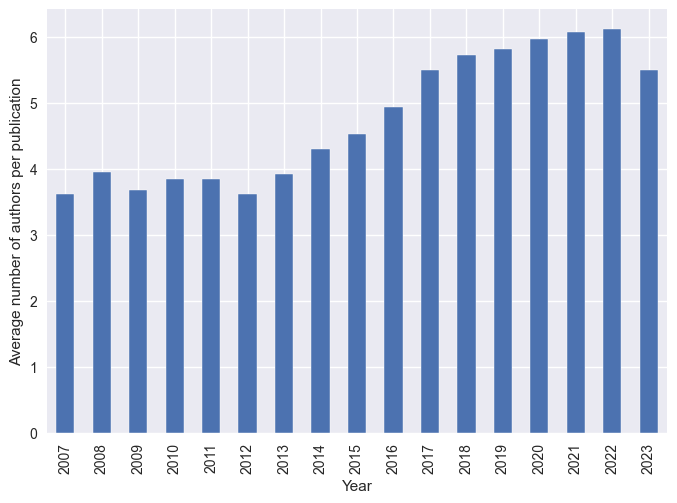

In [21]:
df_describe.groupby(df_describe["article date"].dt.year)['article authors'].mean().plot(kind='bar', xlabel='Year', ylabel='Average number of authors per publication')

#### Averagr number of authors per paper

In [134]:
print("Average number of authors =",df_describe["article authors"].mean())

Average number of authors = 5.485488929012639


#### Number of papers published per year

We can see that this event that caused some change in the number of authors in 2014 is also reflected in the total number of papers published in that year. 2019 is the only other year were we see a slight dip in papers published. 

<AxesSubplot:xlabel='Year', ylabel='number of papers published'>

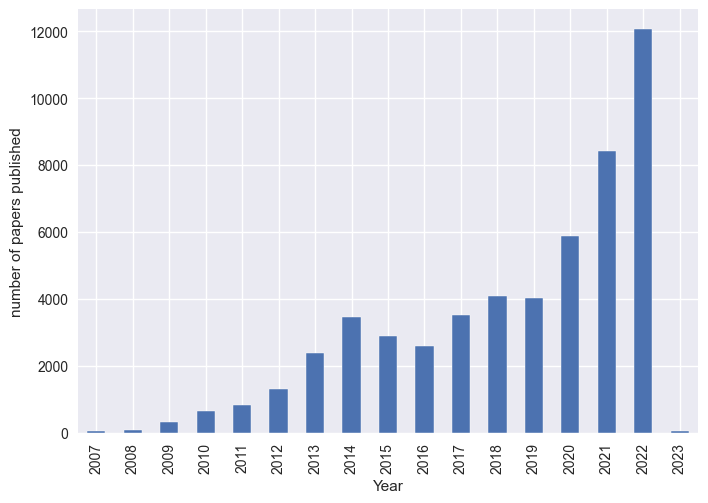

In [22]:
df_articles_by_date = df_describe.groupby(df_describe["article date"].dt.year).count()
df_articles_by_date["article date"].plot(kind='bar', xlabel='Year', ylabel='number of papers published')

### Trends in the top 100 most cited papers
Looking at the top 100 most cited papers across all journals may help provide some context. Considering we are interested in innovation it will be interesting to see if these papers are representative of the data we have already looked at. Straight away we can see that the average number of authors in the top 100 most cited papers is about 4. Much lower than the average.

In [23]:
df_top_citations = df_describe.nlargest(n=100, columns=['citations'])
print("Average number of authors in top 100 most cited papers =",df_top_citations["article authors"].mean())

Average number of authors in top 100 most cited papers = 4.05


#### Journals in the top 100 most cited papers.
We can see here that Frontiers in Neurology, even though it has the most papers by quite a margin, scores very low in terms of citations in the top 100 papers. This could be due to the fact the neurology is very specialised and so while a lot of papers can be produced in specialist areas they are not necessarily the most cited or relevant to the field at large. Frontiers in Human Neuroscience comes in at number one. Surprisingly Frontiers in Systems Neuroscience and Neuroinformatics feature significantly in the top 100. Given that systems neuroscience is closely associated with theoretical neuroscience. Frontiers in Neuroinformatics could be benefiting from recent advances in computational techniques and possibly taking advantage of the abundance of data produced from the original research papers.

<AxesSubplot:xlabel='journal name', ylabel='number of papers'>

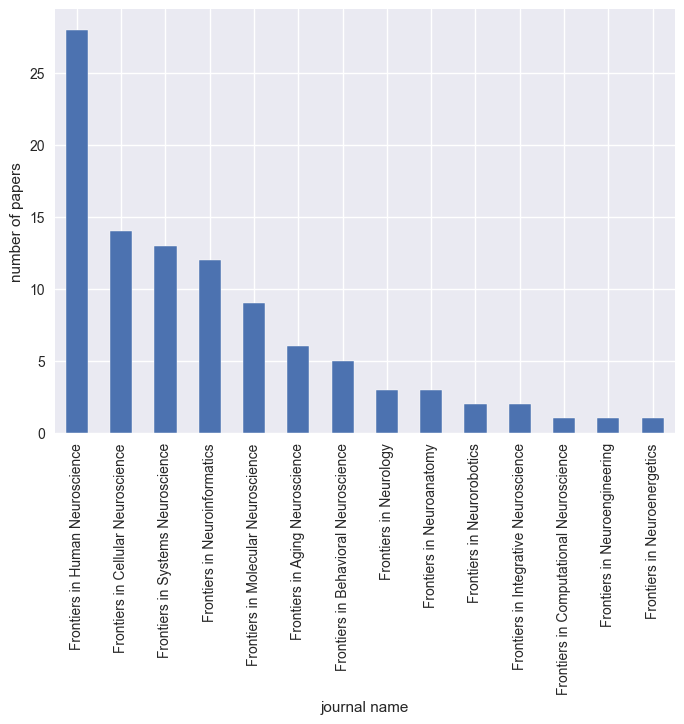

In [24]:
df_top_citations['article journal'].value_counts().plot(kind='bar', xlabel='journal name', ylabel='number of papers')

#### Article type in the top 100 most cited papers
Interestingly here we see review papers are the most cited among the top 100 most cited papers. This makes sense with such an abundance of original research. The results need to be reviewed and contrasted to get an idea of what they mean. And with a lack of hypothesis and theory to guide research this function may have been taken up by the review articles. One possibility is that it might be easier to put forward ideas in review articles than in hypothesis and theory articles because of stigma towards the wording or other social reasons. Furthermore, we can see that the hypothesis and theory articles do feature in the top 100 indicating they may still have a significant impact despite their sparsity. Methods scoring highly may reflect the reliance and complexity of the tools used in neuroscience to derive results.

<AxesSubplot:xlabel='article type', ylabel='number of papers'>

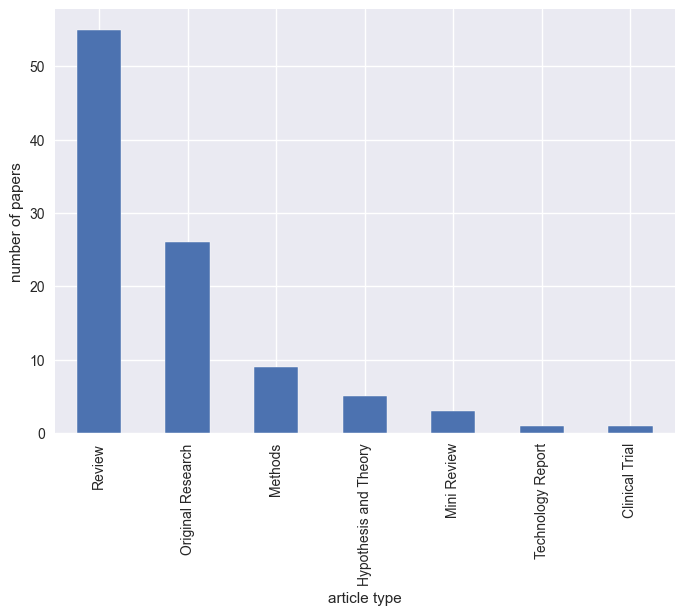

In [25]:
df_top_citations['article type'].value_counts().plot(kind='bar', xlabel='article type', ylabel='number of papers')

#### Predicting articles per year
Given the result above I tested to see if including both reviews and hypothesis and theory articles could predict their amount of articles over time and the answer is no. There are not enough data points, and the outliers are too great for this model to work. possibly a finer grained model could work, maybe by month.

In [135]:
df_articles_per_year_temp = df_describe.groupby(df_describe["article date"].dt.year)['article type'].value_counts().to_frame()

df_articles_per_year_temp.rename(columns = {'article type':'number of articles'}, inplace = True)
df_articles_per_year = df_articles_per_year_temp.reset_index()

df_hyp = df_articles_per_year.loc[df_articles_per_year["article type"].isin(['Reviews', 'Hypothesis and Theory',])]

The Rsqr is:  -0.2705393362513264
The RMSE is:  51.64055930490759


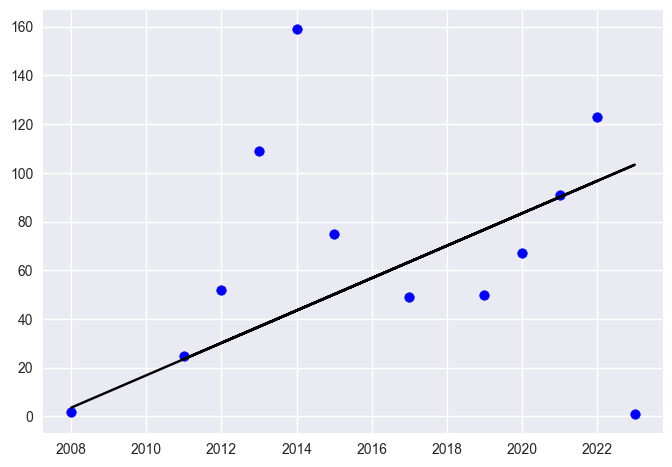

In [136]:
model = LinearRegression()

X = np.array(df_hyp["article date"]).reshape(-1, 1)
y = np.array(df_hyp["number of articles"]).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.3)

model.fit(X_train, y_train)

predictions = model.predict(X_test)
r2 = r2_score(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)

print('The Rsqr is: ', r2)
print('The RMSE is: ', rmse)

y_pred = model.predict(X_test)
plt.scatter(X_test, y_test, color ='b')
plt.plot(X_test, y_pred, color ='k')

### Summary for the numerical analysis of all journals

The data clearly shows a large difference between the number of hypothesis and theory articles and original research articles which is broadly assumed to be experimental and analytical work. In terms of the aims and objectives is does seem to be the case that experimental work represented by original research far outnumbers that of theoretical work. Frontiers in Neurology, Human Neuroscience, and Neuroscience account for around 50% of all the papers published across the neuroscience journals. In general papers with fewer authors are less common with the maximum 10 authors being the most common. This trend for increasing number of authors is observed to have begun in 2013/2014. The number of papers published per year also dropped following 2014 and resumed an upwards trend around 2016. However, the number of authors does not seem to correlate with article citations or views. There is also a lack of obvious correlation between views and citations although this may be heavily influenced by the outliers.

In the top 100 most cited papers the average number of authors is 4 whereas for all articles it is 5.5. Review articles are the most common in the top 100 most cited articles. Given the volume of original research we can see that reviews are very popular in terms of citations, and this could possibly indicate more review work is required to produce hypothesis and theory articles of significance. Theoretical work features in to the top 100 most cited articles accounting for around 5% of the total articles. The ideal ratio of theoretical to experimental work is still unclear but this could be used as a baseline figure moving forward for comparison.

## Analysis of Hypothesis and Theory Articles Numerical Data
Now we have an idea of trends across all the journals we can take a closer look at the hypothesis and theory articles specifically and contrast them with the previous findings. Starting by extracting all hypothesis and theory articles it can be seen that all 957 hypothesis and theory articles acount for only 1.8% of the total 52615 articles. This is well below the 5% we observed in the top 100 most cited papers in the previous section.

In [28]:
df_hypothesis = df_describe.copy()
df_hypothesis = df_hypothesis.loc[df_hypothesis["article type"] == "Hypothesis and Theory"]
df_hypothesis.shape

(957, 18)

#### Hypothesis and theory articles by year
Immediately we can see that there is a drastic change in the number of hypothesis and theory articles produced after 2014 which lines up with what was previously observed. Looking at the Frontiers website they have a history section available at this link: https://www.frontiersin.org/about/history. Under 2013 the following event is documented:

2013
- "The Holtzbrinck Publishing Group, at the time owner of Nature Publishing Group and later majority shareholder of Springer Nature, makes an investment in Frontiers and a Holtzbrinck representative is appointed to the Frontiers Board of Directors"

There are no additional major organisational changes documented under the 2012 or 2014 sections of this page. This does not definitively mean that this investment and the appointment of the Holtzbrinck representative to the Frontiers board of directors in 2013 was the direct cause of this decline in published articles but a factor worth considering. As we can see from the graph the number of hypothesis and theory papers did begin to increase again post 2019 which also matches up with the earlier analysis of all the journals. However, it has not reached its previous height in 2014. It is also worth mentioning that the growth in number of articles now seems to be increasing at a steady rate compared to the steeper curve seen leading up to 2014 possibly suggesting a decline in new ideas, or again, an increase in the difficulty of problems to be solved. 

In 2019 the following events are reported:

2019 
- new open access publishing agreement with the UK
- integration with Chronos and BioRxiv

These two events could have contributed to Frontiers having greater access to publishable work and therefore the increase in papers we see post 2019.


<AxesSubplot:xlabel='Year', ylabel='number of papers published'>

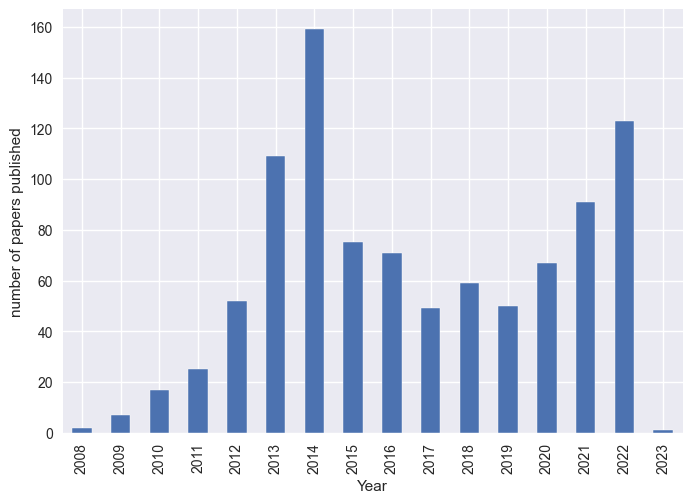

In [29]:
df_hyp_articles_by_date = df_hypothesis.groupby(df_describe["article date"].dt.year).count()
df_hyp_articles_by_date["article date"].plot(kind='bar', xlabel='Year', ylabel='number of papers published')

#### Number of authors per paper for hypothesis and theory articles
Interestingly we see almost the reverse trend in hypothesis and theory articles with fewer authors being much more common. This could also be an indication that the proclivity of modern research to be done in larger groups makes it harder to produce theoretical work. This assumption would need to be contrasted against other research types to be surer.

<AxesSubplot:>

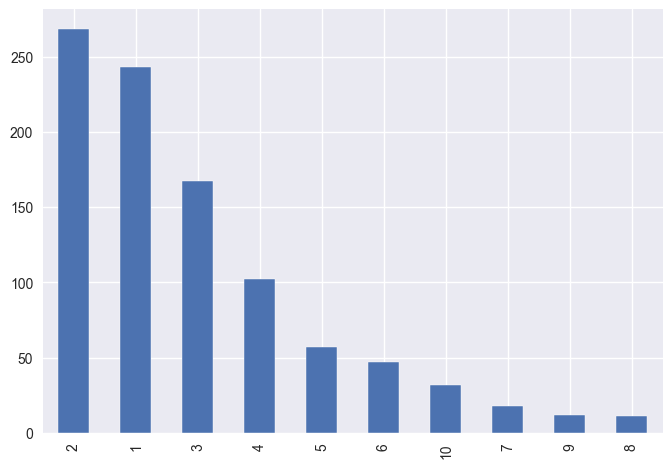

In [30]:
df_hypothesis['article authors'].value_counts().plot(kind='bar')

#### Average number of authors an article has per year
This shows a slight increase but not to the extent of the general population of articles. It seems that number of authors may be a significant factor in producing theoretical work.

<AxesSubplot:xlabel='Year', ylabel='Average number of authors per publication'>

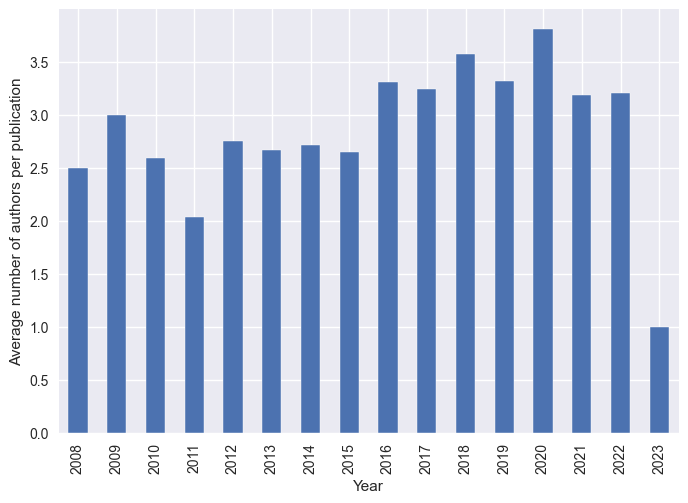

In [31]:
df_hypothesis.groupby(df_hypothesis["article date"].dt.year)['article authors'].mean().plot(kind='bar', xlabel='Year', ylabel='Average number of authors per publication')

#### Number of Hypothesis and theory papers published per journal 
Here we can see there seems to be a lot of theoretical work coming out of systems and computational neuroscience journals relative to the significantly larger human neuroscience and neurology journals. This makes sense as systems and computational neuroscience are associated with theoretical work and also leveraging skills and resources in computer science and systems theory. This makes these areas more adapt to dealing experimental data and applying systems thinking to problems which stands in contrast to the more traditional reductionist approaches.

<AxesSubplot:xlabel='Journal name', ylabel='number of articles'>

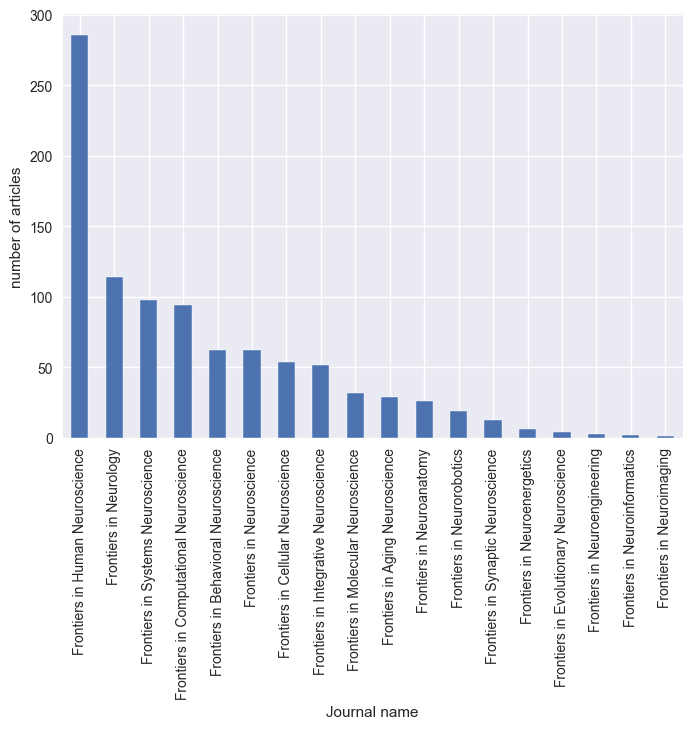

In [32]:
df_hypothesis['article journal'].value_counts().plot(kind='bar', xlabel='Journal name', ylabel='number of articles')

## Summary for the numerical analysis of hypothesis and theory papers 
Hypothesis and theory articles account for only 1.8% of the total articles across all journals. Its possible that The Holtzbrinck Publishing Group investment and representative appointed to the Frontiers Board of Directors could have been a factor in effecting the publications output post 2013 and that this also effected hypothesis and theory articles. 

Around 650 articles, approximately 66% of all hypothesis and theory articles, have 3 authors or less with 2 authors being the most common. This is in stark contrast to what we observed when looking at all the journals together. This indicates that theoretical work is likely best done in small groups or by individuals possibly due to the abstract nature of the work.

Finally, we see Frontiers in Human neuroscience and neurology as high contributors to theoretical work followed by systems and computational neuroscience.

## Analysis of Hypothesis and Theory Articles Text Data
Now we have compared the numerical data we can look at the text data from the titles of each article and use that to identify articles of interest. The nltk library here is being used to process the text data. Once the text data is extracted and processed sentiment analysis and TF-IDF can be used to try and determine if there are any significant patterns in the data related to the aims and objectives.

In [33]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\josh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\josh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Prepare article titles text
Convert all the article titles to one string and tokenize the words removing all punctuation and stop words. This will provide clearer output. Using python set we can get an idea of how large the vocabulary we are dealing with will be. Given the technical nature of this topic we would expect this to be fairly large.  

In [34]:
titles = df_hypothesis["article title"].to_string()
words = word_tokenize(titles)

In [35]:
def clean_tokens(words):
    stop_words = set(stopwords.words('english'))
    words = [word.lower() for word in words if word.isalpha()]
    tokens = [word for word in words if word not in stop_words]
    return tokens

In [36]:
vocabulary = set(clean_tokens(words))
print("vocabulary =", len(vocabulary))

vocabulary = 2178


#### Most frequent words in Hypothesis and theory article titles.
Looking at this frequency distribution would suggest that cognition, consciousness, memory, and sleep are some of the most popular topics. This is a possible indication that understanding cognition, consciousness, memory, and sleep are of primary importance for the field of neuroscience which at the present time seems very plausible.

It is also interesting to note that behind "brain", "model" is the second most commonly occurring word. Occurring even more than hypothesis or theory. This could also reflect the tight link between computational modelling and current neuroscientific theorising. It is also evidence that producing models of neurological functions is more popular than developing more theoretical frameworks. It is also possible that academia has been influenced by the rise in popularity of artificial neural network models in industry. Considering much of the tools are open source such as TensorFlow and PyTorch it makes it a lot easier to develop complex models.

In [37]:
def plot_frequency_distribution(tokens):
    frequency_dist = nltk.FreqDist(tokens)
    fd = frequency_dist.most_common(20)
    pd.DataFrame(fd, columns=['word','occurances']).set_index('word').plot(kind='bar');

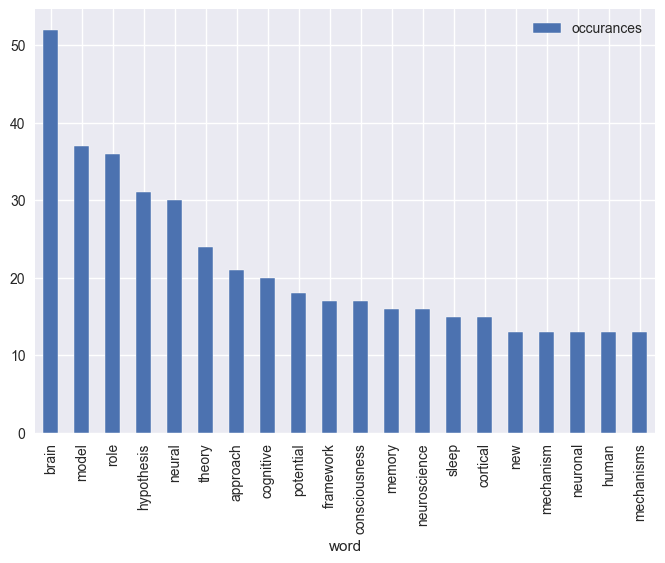

In [38]:
tokens = clean_tokens(words)
plot_frequency_distribution(tokens)

#### Most frequent words across all journal article titles
Contrasting this finding with all the journals, the word "cognitive" also scores highly across articles explaining the popularity in papers regarding cognition. It has just under 1000 mentions while consciousness only has 47. This shows that consciousness is probably a popular topic in the realm of theoretical thinking, but cognition is more widely discussed in the literature. This could be because cognitive functions are much more easily identified and correlated with neurological activity via techniques such as fMRI so they can be experimented on whereas consciousness is a notoriously hard problem to design experiments for.

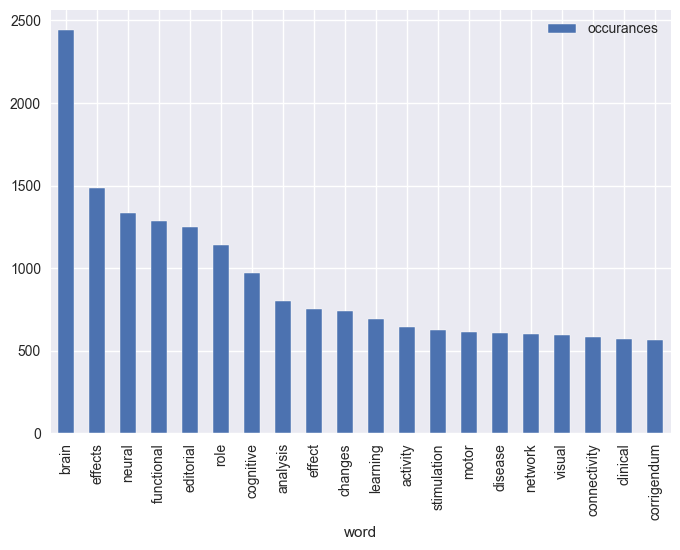

In [39]:
df_words = df_handle_nulls.copy()
df_words.rename(columns={'Unnamed: 0':'article title'}, inplace=True)

all_titles = df_words["article title"].to_string()
all_words = word_tokenize(all_titles)

all_words_tokens = clean_tokens(all_words)
plot_frequency_distribution(all_words_tokens)

#### Comparing the most cited consciousness and cognitive articles.
Articles on consciousness and cognition scored the highest of the identified topics and so will be investigated further. It is also important to keep in mind that memory and sleep were not far behind. To get an idea of how the authors feel about the issues they are talking about in these papers we can use the following techniques:
- Sentiment analysis
- TF-IDF

First, we identify all the articles that contain the words consciousness, conscious, cognitive and cognition in the title to make sure we capture as many relevant articles as possible. Then the top 5 most cited of each are sampled for comparison.

In [40]:
df_consciousness = df_hypothesis.loc[df_hypothesis['article title'].str.contains("consciousness | conscious", case=False)]
df_cognitive = df_hypothesis.loc[df_hypothesis['article title'].str.contains("cognitive | cognition", case=False)]
print("consciousness =", df_consciousness.shape)
print("cognitive =", df_cognitive.shape)

consciousness = (37, 18)
cognitive = (70, 18)


In [41]:
df_consciousness.nlargest(n=6, columns=['citations'])

,article title,article type,article date,article status,article journal,1,2,3,article authors,views,citations,4,5,6,7,8,9,10
34943,The entropic brain: a theory of conscious stat...,Hypothesis and Theory,2014-02-03,Published,Frontiers in Human Neuroscience,Robin Lester Carhart-Harris,Robert Leech,Peter John Hellyer,8,404531.0,405.0,Murray Shanahan,Amanda Feilding,Enzo Tagliazucchi,Dante R Chialvo,David Nutt,None,None
22207,Coupling the State and Contents of Consciousness,Hypothesis and Theory,2019-08-30,Published,Frontiers in Systems Neuroscience,Jaan Aru,Mototaka Suzuki,Renate Rutiku,5,36436.0,50.0,Matthew E. Larkum,Talis Bachmann,None,None,None,None,None
25492,The Emergence of Primary Anoetic Consciousness...,Hypothesis and Theory,2014-01-03,Published,Frontiers in Behavioral Neuroscience,Marie Vandekerckhove,Luis Carlo Bulnes,Jaak Panksepp,3,13778.0,35.0,None,None,None,None,None,None,None
11137,The claustrum’s proposed role in consciousness...,Hypothesis and Theory,2014-02-26,Published,Frontiers in Integrative Neuroscience,Klaus M Stiefel,Alistair Merrifield,Alex O Holcombe,3,38473.0,29.0,None,None,None,None,None,None,None
33584,Restructuring consciousness –the psychedelic s...,Hypothesis and Theory,2015-06-12,Published,Frontiers in Human Neuroscience,Andrew R. Gallimore,None,None,1,47864.0,27.0,None,None,None,None,None,None,None
24805,A neurophenomenological model for the role of ...,Hypothesis and Theory,2015-08-26,Published,Frontiers in Behavioral Neuroscience,Gianfranco Dalla Barba,Valentina La Corte,None,2,6686.0,16.0,None,None,None,None,None,None,None


In [42]:
df_cognitive.nlargest(n=6, columns=['citations'])

,article title,article type,article date,article status,article journal,1,2,3,article authors,views,citations,4,5,6,7,8,9,10
32626,Allostatic Self-efficacy: A Metacognitive Theo...,Hypothesis and Theory,2016-11-15,Published,Frontiers in Human Neuroscience,Klaas E. Stephan,Zina M. Manjaly,Christoph D. Mathys,10,26853.0,177.0,Lilian A. E. Weber,Saee Paliwal,Tim Gard,Marc Tittgemeyer,Stephen M. Fleming,Helene Haker,Anil K. Seth
36436,Mental Training as a Tool in the Neuroscientif...,Hypothesis and Theory,2011-02-10,Published,Frontiers in Human Neuroscience,Heleen A Slagter,Richard J Davidson,Antoine Lutz,3,77225.0,162.0,None,None,None,None,None,None,None
33728,Neurocognitive poetics: methods and models for...,Hypothesis and Theory,2015-04-16,Published,Frontiers in Human Neuroscience,Arthur M. Jacobs,None,None,1,29316.0,129.0,None,None,None,None,None,None,None
5556,Neuronal and Cognitive Plasticity: A Neurocogn...,Hypothesis and Theory,2010-11-29,Published,Frontiers in Aging Neuroscience,Pamela M Greenwood,Raja Parasuraman,None,2,31884.0,112.0,None,None,None,None,None,None,None
39433,Can Ketones Help Rescue Brain Fuel Supply in L...,Hypothesis and Theory,2016-07-08,Published,Frontiers in Molecular Neuroscience,Stephen C. Cunnane,Alexandre Courchesne-Loyer,Camille Vandenberghe,10,108912.0,105.0,Valérie St-Pierre,Mélanie Fortier,Marie Hennebelle,Etienne Croteau,Christian Bocti,Tamas Fulop,Christian-Alexandre Castellano
5595,An epigenetic hypothesis of aging-related cogn...,Hypothesis and Theory,2010-03-12,Published,Frontiers in Aging Neuroscience,Marsha R Penner,Tania L Roth,Carol Barnes,4,17590.0,99.0,David Sweatt,None,None,None,None,None,None


#### Preparing article data
Here the link to each article is stored in a variable with its index number to make it identifiable. Then each article is retrieved using selenium and processed to extract the main article text and remove the references. 

In [43]:
article_32626 = "https://www.frontiersin.org/articles/10.3389/fnhum.2016.00550/full"
article_36436 = "https://www.frontiersin.org/articles/10.3389/fnhum.2011.00017/full"
article_33728 = "https://www.frontiersin.org/articles/10.3389/fnhum.2015.00186/full"
article_5556 = "https://www.frontiersin.org/articles/10.3389/fnagi.2010.00150/full"
article_39433 = "https://www.frontiersin.org/articles/10.3389/fnmol.2016.00053/full"

cognition_articles = [article_32626, article_36436, article_33728, article_5556, article_39433]

In [44]:
article_34943 = "https://www.frontiersin.org/articles/10.3389/fnhum.2014.00020/full"
article_22207 = "https://www.frontiersin.org/articles/10.3389/fnsys.2019.00043/full"
article_25492 = "https://www.frontiersin.org/articles/10.3389/fnbeh.2013.00210/full"
article_11137 = "https://www.frontiersin.org/articles/10.3389/fnint.2014.00020/full"
article_33584 = "https://www.frontiersin.org/articles/10.3389/fnhum.2015.00346/full"

conscious_articles = [article_34943, article_22207, article_25492, article_11137, article_33584] 

In [45]:
def get_specified_articles(articles):
    article_soup = []
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
    for article in articles:
        check_page_response(article)
        driver.get(article)
        article_soup.append(BeautifulSoup(driver.page_source, 'html.parser'))
    return article_soup

In [46]:
def get_article_html(article_soup):
    article_html = []
    for article in article_soup:
        target = article.find('div', class_='References')
        if target != None: 
            for reference in target.find_all_next():
                reference.clear()
        article_html.append(article.find('div', class_='JournalFullText'))
    return article_html

In [47]:
conscious_article_soup = get_specified_articles(conscious_articles)
cognition_article_soup = get_specified_articles(cognition_articles)

conscious_article_html = get_article_html(conscious_article_soup)
cognition_article_html = get_article_html(cognition_article_soup)

<Response [200]> https://www.frontiersin.org/articles/10.3389/fnhum.2014.00020/full
<Response [200]> https://www.frontiersin.org/articles/10.3389/fnsys.2019.00043/full
<Response [200]> https://www.frontiersin.org/articles/10.3389/fnbeh.2013.00210/full
<Response [200]> https://www.frontiersin.org/articles/10.3389/fnint.2014.00020/full
<Response [200]> https://www.frontiersin.org/articles/10.3389/fnhum.2015.00346/full
<Response [200]> https://www.frontiersin.org/articles/10.3389/fnhum.2016.00550/full
<Response [200]> https://www.frontiersin.org/articles/10.3389/fnhum.2011.00017/full
<Response [200]> https://www.frontiersin.org/articles/10.3389/fnhum.2015.00186/full
<Response [200]> https://www.frontiersin.org/articles/10.3389/fnagi.2010.00150/full
<Response [200]> https://www.frontiersin.org/articles/10.3389/fnmol.2016.00053/full


In [48]:
print(len(cognition_article_html))

5


In [49]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\josh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

#### Sentiment analysis of documents
The results of the sentiment analysis show that the articles on cognition are very slightly more positive than those on consciousness. However, overall these articles are neutral in terms of their sentiment which makes sense given the nature of reporting scientific findings but unfortunately it does not help us understand the sentiment towards these topics.

In [50]:
def get_article_sentiment(article_html):
    sia = SentimentIntensityAnalyzer()
    for article in article_html:
        print(sia.polarity_scores(article.text))

In [51]:
print("Cognition article sentiment")
get_article_sentiment(cognition_article_html)
print("-----------------------------------------------")
print("consciousness article sentiment")
get_article_sentiment(conscious_article_html)

Cognition article sentiment
{'neg': 0.068, 'neu': 0.859, 'pos': 0.072, 'compound': 0.9871}
{'neg': 0.022, 'neu': 0.876, 'pos': 0.101, 'compound': 1.0}
{'neg': 0.026, 'neu': 0.869, 'pos': 0.106, 'compound': 1.0}
{'neg': 0.042, 'neu': 0.849, 'pos': 0.109, 'compound': 1.0}
{'neg': 0.052, 'neu': 0.871, 'pos': 0.077, 'compound': 0.9998}
-----------------------------------------------
consciousness article sentiment
{'neg': 0.047, 'neu': 0.865, 'pos': 0.088, 'compound': 1.0}
{'neg': 0.022, 'neu': 0.915, 'pos': 0.063, 'compound': 0.9996}
{'neg': 0.031, 'neu': 0.91, 'pos': 0.059, 'compound': 0.9994}
{'neg': 0.039, 'neu': 0.899, 'pos': 0.061, 'compound': 0.9979}
{'neg': 0.03, 'neu': 0.895, 'pos': 0.075, 'compound': 0.9999}


#### Most common words in top 5 cited cognition and consciousness articles
Identifying the most common words across each set of 5 articles gives some clear targets to analyse with TF-IDF.

In [52]:
def get_article_tokens(article_html):
    article_tokens = []
    for article in article_html:
        article_words = word_tokenize(article.text)
        all_article_words_tokens = clean_tokens(article_words)
        article_tokens.append(all_article_words_tokens)
    return article_tokens

def get_combined_article_tokens(article_tokens):
    combined_article_tokens = []
    for article in article_tokens:
        combined_article_tokens.extend(article)
    return combined_article_tokens

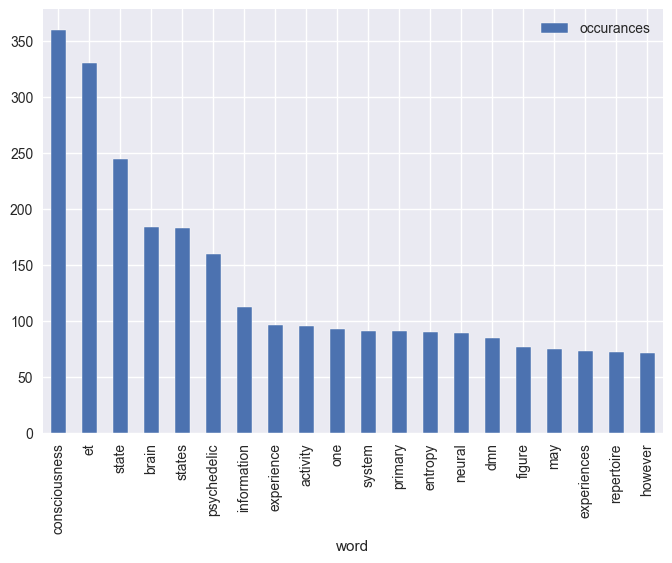

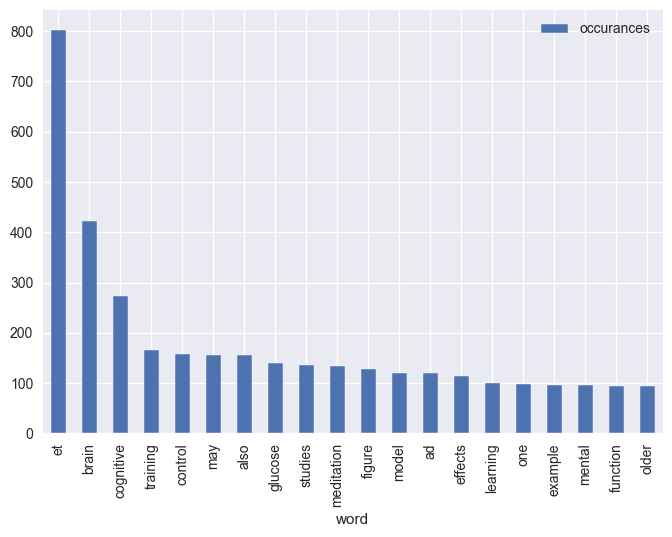

In [53]:
con_article_tokens = get_combined_article_tokens(get_article_tokens(conscious_article_html))
cog_article_tokens = get_combined_article_tokens(get_article_tokens(cognition_article_html))

plot_frequency_distribution(con_article_tokens)
plot_frequency_distribution(cog_article_tokens)

#### TF-IDF analysis 
Here we use scikit learn to vectorize the text data from each article and calculate the TF-IDF and document frequency of the most common words identified across both cognition and consciousness articles.  

In [54]:
def get_article_text(article_html):
    article_text_only = []
    for article in article_html:
        article_text_only.append(article.text)
    return article_text_only

In [55]:
consciousness_article_ids = ["article_34943", "article_22207", "article_25492", "article_11137", "article_33584"]
cognition_article_ids = ["article_32626", "article_36436", "article_33728", "article_5556", "article_39433"]

In [105]:
def get_tfidf_df(article_text, article_ids):
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_vector = tfidf_vectorizer.fit_transform(article_text)
    tfidf_vectorizer.get_feature_names_out()
    tfidf_df = pd.DataFrame(tfidf_vector.toarray(), index=article_ids, columns=tfidf_vectorizer.get_feature_names_out())
    tfidf_df.loc['Document Frequency'] = (tfidf_df > 0).sum()
    tfidf_df.loc['Total TF-IDF '] = tfidf_df.sum(axis=0)
    return tfidf_df

In [106]:
con_tfidf_df = get_tfidf_df(get_article_text(conscious_article_html), consciousness_article_ids)
cog_tfidf_df = get_tfidf_df(get_article_text(cognition_article_html), cognition_article_ids)

In [128]:
def display_target_words_tfidf(tfidf_df, target_words):
    tfidf_slice = tfidf_df[target_words]
    tfidf_slice.sort_index()
    display(tfidf_slice)
    return tfidf_slice

In [129]:
con_target_words = ["consciousness", "cognitive", "memory", "sleep", "psychedelic", "information", "model", "learning", "state"]
cog_target_words = ["cognitive", "memory", "sleep", "glucose", "information", "training", "meditation", "model", "learning", "state"]

print("TF-IDF for target words in consciousness articles")
con_tfidf = display_target_words_tfidf(con_tfidf_df, con_target_words)

print("------------------------------------------------------")

print("TF-IDF for target words in cognitive articles")
cog_tfidf = display_target_words_tfidf(cog_tfidf_df, cog_target_words)

TF-IDF for target words in consciousness articles


,consciousness,cognitive,memory,sleep,psychedelic,information,model,learning,state
article_34943,0.209155,0.056729,0.000000,0.021692,0.186385,0.018347,0.019523,0.002169,0.144941
article_22207,0.328526,0.000000,0.000000,0.050445,0.000000,0.029866,0.005044,0.005044,0.174930
article_25492,0.301737,0.082346,0.203362,0.000000,0.000000,0.055660,0.003464,0.055417,0.038083
article_11137,0.137896,0.000000,0.000000,0.006038,0.000000,0.010215,0.000000,0.006038,0.005107
article_33584,0.114935,0.022172,0.003816,0.010658,0.385388,0.166769,0.026645,0.000000,0.272689
Document Frequency,5.000000,3.000000,2.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000
Total TF-IDF,6.092250,3.161247,2.207178,4.088833,2.571773,5.280856,4.054676,4.068670,5.635750


------------------------------------------------------
TF-IDF for target words in cognitive articles


,cognitive,memory,sleep,glucose,information,training,meditation,model,learning,state
article_32626,0.025948,0.005766,0.000000,0.006078,0.021623,0.002026,0.000000,0.146578,0.017044,0.071585
article_36436,0.150505,0.023764,0.010059,0.000000,0.013862,0.347910,0.594299,0.000000,0.142824,0.016390
article_33728,0.056026,0.020543,0.003162,0.000000,0.020543,0.000000,0.000000,0.081697,0.013248,0.006624
article_5556,0.259296,0.072515,0.000000,0.027796,0.008790,0.160597,0.000000,0.002598,0.064951,0.000000
article_39433,0.066828,0.001554,0.000000,0.283957,0.003108,0.000000,0.000000,0.003675,0.000000,0.012862
Document Frequency,5.000000,5.000000,2.000000,3.000000,5.000000,3.000000,1.000000,4.000000,4.000000,4.000000
Total TF-IDF,5.558603,5.124142,2.013221,3.317830,5.067927,3.510533,1.594299,4.234548,4.238068,4.107461


#### TF-IDF results 
To assess the significance of these words we can now look at the Total TF-IDF for each word (also graphed below). From this we could conclude that the highest-ranking hypothesis and research articles by citation with consciousness or conscious in the title put the most emphasis on consciousness, information, and state having TF-IDF scores of 6.09, 5.28 and, 5.64 respectively.

while the highest-ranking hypothesis and research articles by citation with cognition or cognitive in the title put the most emphasis on cognitive, memory, and information having TF-IDF scores of 5.56, 5.12 and 5.07 respectively.

Learning and model both appear frequently and score highly in Total TF-IDF across both sets of articles having values above 4. while sleep is clearly much more important in the consciousness articles that the cognitive.

It is also interesting to note the consciousness papers contain the word cognitive in 3 out of the 5 documents and at a total TF-IDF value of 3.16 which is around half that of the word consciousness itself, but the cognitive papers do not contain the word consciousness at all. This may lead one to assume consciousness requires explanations of cognition for its theories but the reverse may not be true. This may suggest that explanations of cognition could be a useful step in explaining the problem of consciousness. 

Information appears in all 10 articles and is the most common word across all the documents. Assuming that it is used in the context of brain function this would indicate these articles all consider the brain to be processing information and that broadly theories of consciousness seem to be concerned with how information is processed in conscious states while cognitive articles seem more concerned with the relationship between information and memory. This is possibly an overstated assumption given the sample size but the data is quite clear for this small sample.

<AxesSubplot:>

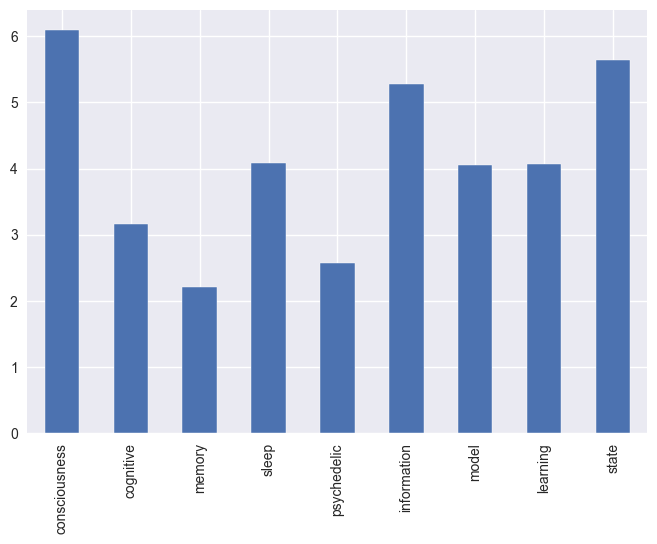

In [130]:
con_tfidf.iloc[6].plot(kind="bar")

<AxesSubplot:>

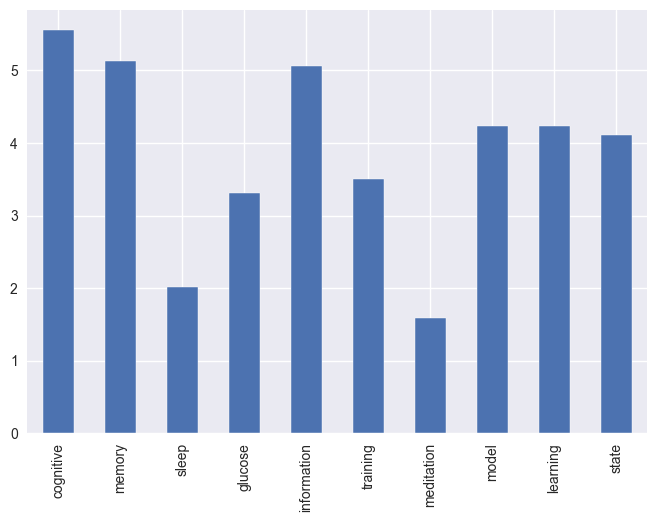

In [131]:
cog_tfidf.iloc[6].plot(kind="bar")

## Conclusions

This section will attempt to round up the findings and relate them to the aims and objectives of the project.

With regards to the second objective, theoretical work in neuroscience seems to be influenced by the type of journal it is published in and the number of authors publishing the research. It doesn’t seem that there is necessarily a lack of theoretical work but more so an abundance of original research. Seeing that Review articles make up the most cited papers in the top 100 most cited papers of all neuroscience journals could indicate that much of original research is very specific work that requires review to be considered in the broader context and is not necessarily a large contribution to the field by itself. This could also speak to the methods of neuroscience becoming more accessible and so more publishable experiments can be run without necessarily decerning anything of value. Additionally given the possible influence of the events in 2013 and 2019 social political and economic factors are likely playing a very significant role in influencing research.

A possibly disadvantage of this approach is ranking the articles impact or significance using citations. While it is true that highly cited articles clearly have some impact in the community it is not necessarily the best metric and may have introduced some bias into the analysis.

For the third objective. Of the theoretical work that is being undertaken, based on citations it appears that hypothesis and theory articles addressing aspects of cognition are the most impactful while articles on consciousness seem to be the most popular among theoreticians. This may show a difference between what is considered important by theoreticians and what is being actively experimented on. Even though these are the most popular topics, combined they still only account for under 4% of the total theoretical papers indicating that there is likely a wide range of topics being addressed. 

It is also notable that models seem popular and likely a product of advances in computational techniques in both academia and industry. Systems and computational neuroscience perform very well in terms producing highly cited hypothesis and theory articles for being much smaller journals than, for example, frontiers in neurology.

For objective four, sentiment analysis on entire articles was not much use. the top theoretical articles on consciousness and cognition were identified which showed that information was the most common and significant word, in terms of TF-IDF, among all of the articles. Memory also seemed to play a significant role in the cognitive papers.

It seems like there is so much more that could be done here, I think the closer analysis of the articles is the way to go. Keeping an eye on the macro trends is important but I think the outside political and economic factors influencing research will always be understood after the fact at that level. Whereas, identifying popular topics and methods at the paper level could possibly give more insight into how to actually make progress in the field.

Overall, I would conclude, based on this work, that theoretical work in neuroscience could be helped to advance by small groups of 3 or less attempting to produce theories of how information is relevant to cognition and consciousness and the role of memory in cognitive processes. Utilising computational methods and ideas from systems theory to understand how current models work and produce new ones that can provide evidence to support new theories.